In [16]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split
import wandb
from wandb.keras import WandbMetricsLogger

### Loading Data

In [41]:
# training_data = datasets.mnist.FashionMNIST(root="data", train=True, download=True)
# test_data = datasets.mnist.FashionMNIST(root="data", train=False, download=True)
# training_data, validation_data = torch.utils.data.random_split(training_data, [50000, 10000])

In [17]:
# Load data from Keras instead of Pytorch
(X_train, y_train), (X_test, y_test) = keras.datasets.fashion_mnist.load_data()
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=10000, shuffle=True, random_state=42)
print(len(X_train), len(y_train), len(X_test), len(y_test))

# One hot encoding
n_classes = 10
y_train = keras.utils.to_categorical(y_train, num_classes=n_classes)
y_val = keras.utils.to_categorical(y_val, num_classes=n_classes)
y_test = keras.utils.to_categorical(y_test, num_classes=n_classes)

print(X_train.shape)
print(y_train.shape)
print(X_val.shape)
print(y_val.shape)
print(X_test.shape)
print(y_test.shape)

50000 50000 10000 10000
(50000, 28, 28)
(50000, 10)
(10000, 28, 28)
(10000, 10)
(10000, 28, 28)
(10000, 10)


### CNN Baseline Model
Model with two CNN layers (including max pooling), one dense and an output classification layer, with suitable number of filters and units, respectively.

In [18]:
def cnn_model(n_classes):
    """
    Model with two CNN layers, one dense and an output classification layer, with suitable number of filters and units, respectively.
    :return:
    """
    ### YOUR CODE HERE
    model = keras.Sequential()
    # First CNN layer
    model.add(keras.layers.Conv2D(filters=32, kernel_size=(3,3), strides=(1, 1), padding='same', activation='relu', input_shape=(28, 28, 1)))
    model.add(keras.layers.MaxPooling2D(pool_size=(2,2)))
    # Second CNN layer
    model.add(keras.layers.Conv2D(filters=32, kernel_size=(3,3), strides=(1, 1), padding='same', activation='relu'))
    model.add(keras.layers.MaxPooling2D(pool_size=(2,2)))
    model.add(keras.layers.Flatten())
    model.add(keras.layers.Dense(units=n_classes))
    model.add(keras.layers.Activation("softmax"))

    return model
    ### YOUR CODE HERE

In [19]:
model = cnn_model(n_classes=n_classes)
print(model.summary())

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 28, 28, 32)        320       
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 14, 14, 32)       0         
 2D)                                                             
                                                                 
 conv2d_9 (Conv2D)           (None, 14, 14, 32)        9248      
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 7, 7, 32)         0         
 2D)                                                             
                                                                 
 flatten_4 (Flatten)         (None, 1568)              0         
                                                                 
 dense_4 (Dense)             (None, 10)               

### Training

Implement the training / evaluation loop
Remember training / validation cost and accuracy per epoch and return them as list.

In [5]:
model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer="sgd",
              metrics=["accuracy"]
             )

### Train Baseline CNN Model

Follow the "Steps to Test and Tune a Model" as presented in the lecture.

Train the baseline with SGD without momentum and fixed learning rate. Tune the learning rate by this procedure.

Determine a suitable number of epochs.

In [5]:
def plot_training_metrics(log):
    f = plt.figure(figsize=(12,4))
    ax1 = f.add_subplot(121)
    ax2 = f.add_subplot(122)
    ax1.plot(log.history['loss'], label='Training loss')
    ax1.plot(log.history['val_loss'], label='Validation loss')
    ax1.legend()
    ax1.grid()
    ax2.plot(log.history['accuracy'], label='Training acc')
    ax2.plot(log.history['val_accuracy'], label='Validation acc')
    ax2.legend()
    ax2.grid()

epoch/accuracy,▁▇▇███████
epoch/epoch,▁▂▃▃▄▅▆▆▇█
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▁▁▁▁▁▁▁▁▁
epoch/val_accuracy,▃▃▇▁▇██▅▇█
epoch/val_loss,▅▆▂█▂▁▂▅▂▁
epoch/accuracy,0.87404
epoch/epoch,9
epoch/learning_rate,0.01
epoch/loss,0.346
epoch/val_accuracy,0.8561


Epoch 1/50
782/782 [==============================] - 2s 3ms/step - loss: 0.3398 - accuracy: 0.8767 - val_loss: 0.3778 - val_accuracy: 0.8688
Epoch 2/50
782/782 [==============================] - 2s 3ms/step - loss: 0.3380 - accuracy: 0.8771 - val_loss: 0.3979 - val_accuracy: 0.8536
Epoch 3/50
782/782 [==============================] - 2s 3ms/step - loss: 0.3338 - accuracy: 0.8792 - val_loss: 0.3925 - val_accuracy: 0.8577
Epoch 4/50
782/782 [==============================] - 2s 3ms/step - loss: 0.3296 - accuracy: 0.8792 - val_loss: 0.4059 - val_accuracy: 0.8553
Epoch 5/50
782/782 [==============================] - 2s 3ms/step - loss: 0.3265 - accuracy: 0.8816 - val_loss: 0.3986 - val_accuracy: 0.8523
Epoch 6/50
782/782 [==============================] - 2s 3ms/step - loss: 0.3230 - accuracy: 0.8818 - val_loss: 0.3794 - val_accuracy: 0.8680
Epoch 7/50
782/782 [==============================] - 2s 3ms/step - loss: 0.3198 - accuracy: 0.8842 - val_loss: 0.3652 - val_accuracy: 0.8704
Epoch 

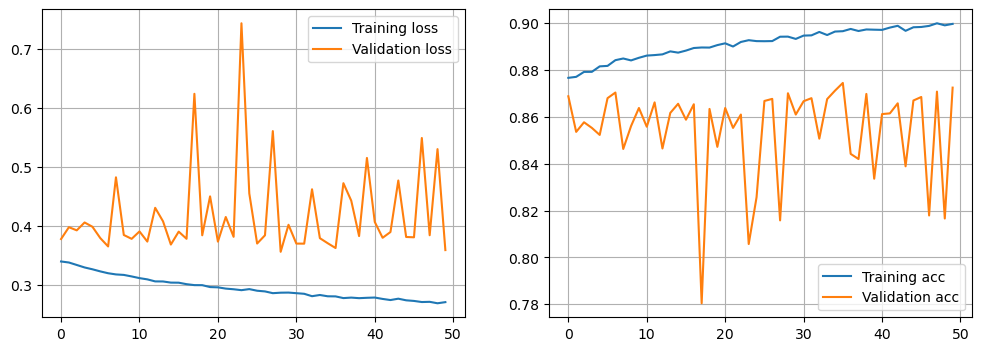

In [11]:
### YOUR CODE HERE ###

# Initialize a new W&B run
wandb.init(config={"bs": 12})

nepochs = 50
batch_size = 64

log = model.fit(
    x=X_train,
    y=y_train,
    batch_size=batch_size,
    epochs=nepochs,
    validation_data=(X_test, y_test),
    callbacks=[WandbMetricsLogger()]
)

# Finish W&B run
wandb.finish()

plot_training_metrics(log)


In [30]:
### YOUR CODE HERE ###
nepochs = 20

lr_list = np.logspace(-8, 1, num=10)

for lr in lr_list:
    print(lr)
    model = cnn_model(n_classes=n_classes)
    model.compile(
        loss=keras.losses.categorical_crossentropy,
        optimizer=keras.optimizers.SGD(learning_rate=lr),
        metrics=["accuracy"]
    )
    
    wandb.init(config={"bs": 12}, name="SGD, lr = " + str(lr))
    log = model.fit(
        x=X_train,
        y=y_train,
        batch_size=batch_size,
        epochs=nepochs,
        validation_data=(X_test, y_test),
        callbacks=[WandbMetricsLogger()],
        verbose=0
    )
    wandb.finish()
    #plot_training_metrics(log)


1e-08


epoch/accuracy,██████████████▁▁▁▁▁▇▁▇█▁▁▁▁▁█▁▁▁▁▁▁▃▆▇▁▁
epoch/epoch,▁▂▂▃▃▄▅▅▆▆▇▇█▁▁▁▁▂▁▁▁▁▂▁▁▁▁▂▁▁▁▁▂▁▁▁▁▂▁▂
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▂▂▂▁▂▁▁▁▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁█
epoch/loss,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁ ▁▁▁▁▁█▁▁▁▁▁▁▁▁▁▁▁▁
epoch/val_accuracy,████▇█████████▁▁▁▁▁█▁▇█▁▁▁▁▁█▁▁▁▁▁▁▃▇█▁▁
epoch/val_loss,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▂▂▂▂▁ ▁▁▂▂▂▂▂▁▂▂▂▂▂█▂▁▁▂
epoch/accuracy,0.09982
epoch/epoch,4
epoch/learning_rate,10.0
epoch/loss,nan
epoch/val_accuracy,0.1


epoch/accuracy,▁▁▁▁▂▂▃▃▄▄▅▅▆▆▆▇▇▇██
epoch/epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▇▇▆▆▆▅▅▄▄▄▃▃▃▂▂▂▂▁▁
epoch/val_accuracy,▂▂▁▁▂▂▃▄▄▅▅▆▆▆▇▇▇███
epoch/val_loss,█▇▇▆▆▆▅▅▄▄▄▃▃▃▂▂▂▂▁▁
epoch/accuracy,0.0943
epoch/epoch,19
epoch/learning_rate,0.0
epoch/loss,22.22972
epoch/val_accuracy,0.0925


wandb: Currently logged in as: micha-luginbuehl. Use `wandb login --relogin` to force relogin


1e-07


epoch/accuracy,▁▂▂▃▄▄▄▄▄▅▅▅▆▆▇▇▇▇██
epoch/epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▆▄▃▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁
epoch/val_accuracy,▁▁▂▃▃▃▄▄▄▅▅▅▆▆▆▇▇▇██
epoch/val_loss,█▆▄▄▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁
epoch/accuracy,0.33932
epoch/epoch,19
epoch/learning_rate,0.0
epoch/loss,6.00839
epoch/val_accuracy,0.3316


1e-06


epoch/accuracy,▁▃▄▅▆▆▆▆▇▇▇▇▇▇██████
epoch/epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▃▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁
epoch/val_accuracy,▁▃▄▅▅▆▆▆▇▇▇▇▇▇██████
epoch/val_loss,█▅▄▄▃▃▃▂▂▂▂▂▂▁▁▁▁▁▁▁
epoch/accuracy,0.61558
epoch/epoch,19
epoch/learning_rate,0.0
epoch/loss,2.00968
epoch/val_accuracy,0.6126


1e-05


epoch/accuracy,▁▄▅▆▆▇▇▇▇▇▇█████████
epoch/epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/val_accuracy,▁▃▄▅▆▆▆▇▇▇▇▇▇███████
epoch/val_loss,█▅▄▃▃▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁
epoch/accuracy,0.76684
epoch/epoch,19
epoch/learning_rate,1e-05
epoch/loss,0.74684
epoch/val_accuracy,0.7598


0.0001


epoch/accuracy,▁▄▅▆▆▆▇▇▇▇▇▇▇███████
epoch/epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/val_accuracy,▁▃▄▅▆▆▆▇▇▇▇▇▇▇▇█████
epoch/val_loss,█▆▄▄▃▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁
epoch/accuracy,0.86552
epoch/epoch,19
epoch/learning_rate,0.0001
epoch/loss,0.38853
epoch/val_accuracy,0.8496


0.001


epoch/accuracy,▁▅▅▆▆▇▇▇▇▇▇▇████████
epoch/epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁
epoch/val_accuracy,▁▄▄▅▅▆▆▆▇▇▇▇▇▅▇█▇▇██
epoch/val_loss,█▅▅▄▄▃▃▂▂▂▂▂▂▄▂▁▁▂▁▁
epoch/accuracy,0.90976
epoch/epoch,19
epoch/learning_rate,0.001
epoch/loss,0.25639
epoch/val_accuracy,0.8814


0.01


epoch/accuracy,▁▆▇▇▇▇▇█████████████
epoch/epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/val_accuracy,▁▄▄▆▇▆▆▇▇▇▇██▇▇██▇██
epoch/val_loss,█▅▄▂▂▃▃▁▂▂▂▁▁▂▂▁▂▂▁▁
epoch/accuracy,0.88654
epoch/epoch,19
epoch/learning_rate,0.01
epoch/loss,0.31352
epoch/val_accuracy,0.8616


0.1


epoch/accuracy,▆▃▄▄▄▆▆▆▁▄▄▄▃█▄▃▅▄▆▅
epoch/epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/val_accuracy,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/val_loss,▆▆▆▃▃▄▃▃▃█▆▃▆▄▁▃▂▂▇▂
epoch/accuracy,0.099
epoch/epoch,19
epoch/learning_rate,0.1
epoch/loss,2.30305
epoch/val_accuracy,0.1


1.0


epoch/accuracy,▄▄▅▄▄▅▄▇▁▃▆▂▃█▇▅▆█▆▅
epoch/epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/val_accuracy,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/val_loss,▃▆▂▃▅▆▂▆▇█▄▁▄▇▂▁█▆▄▆
epoch/accuracy,0.09992
epoch/epoch,19
epoch/learning_rate,1.0
epoch/loss,2.30646
epoch/val_accuracy,0.1


10.0


epoch/accuracy,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/val_accuracy,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/accuracy,0.09982
epoch/epoch,19
epoch/learning_rate,10.0
epoch/loss,nan
epoch/val_accuracy,0.1
epoch/val_loss,nan


With 20 epochs and plain SGD setting the learning rate = 0.001 performs best
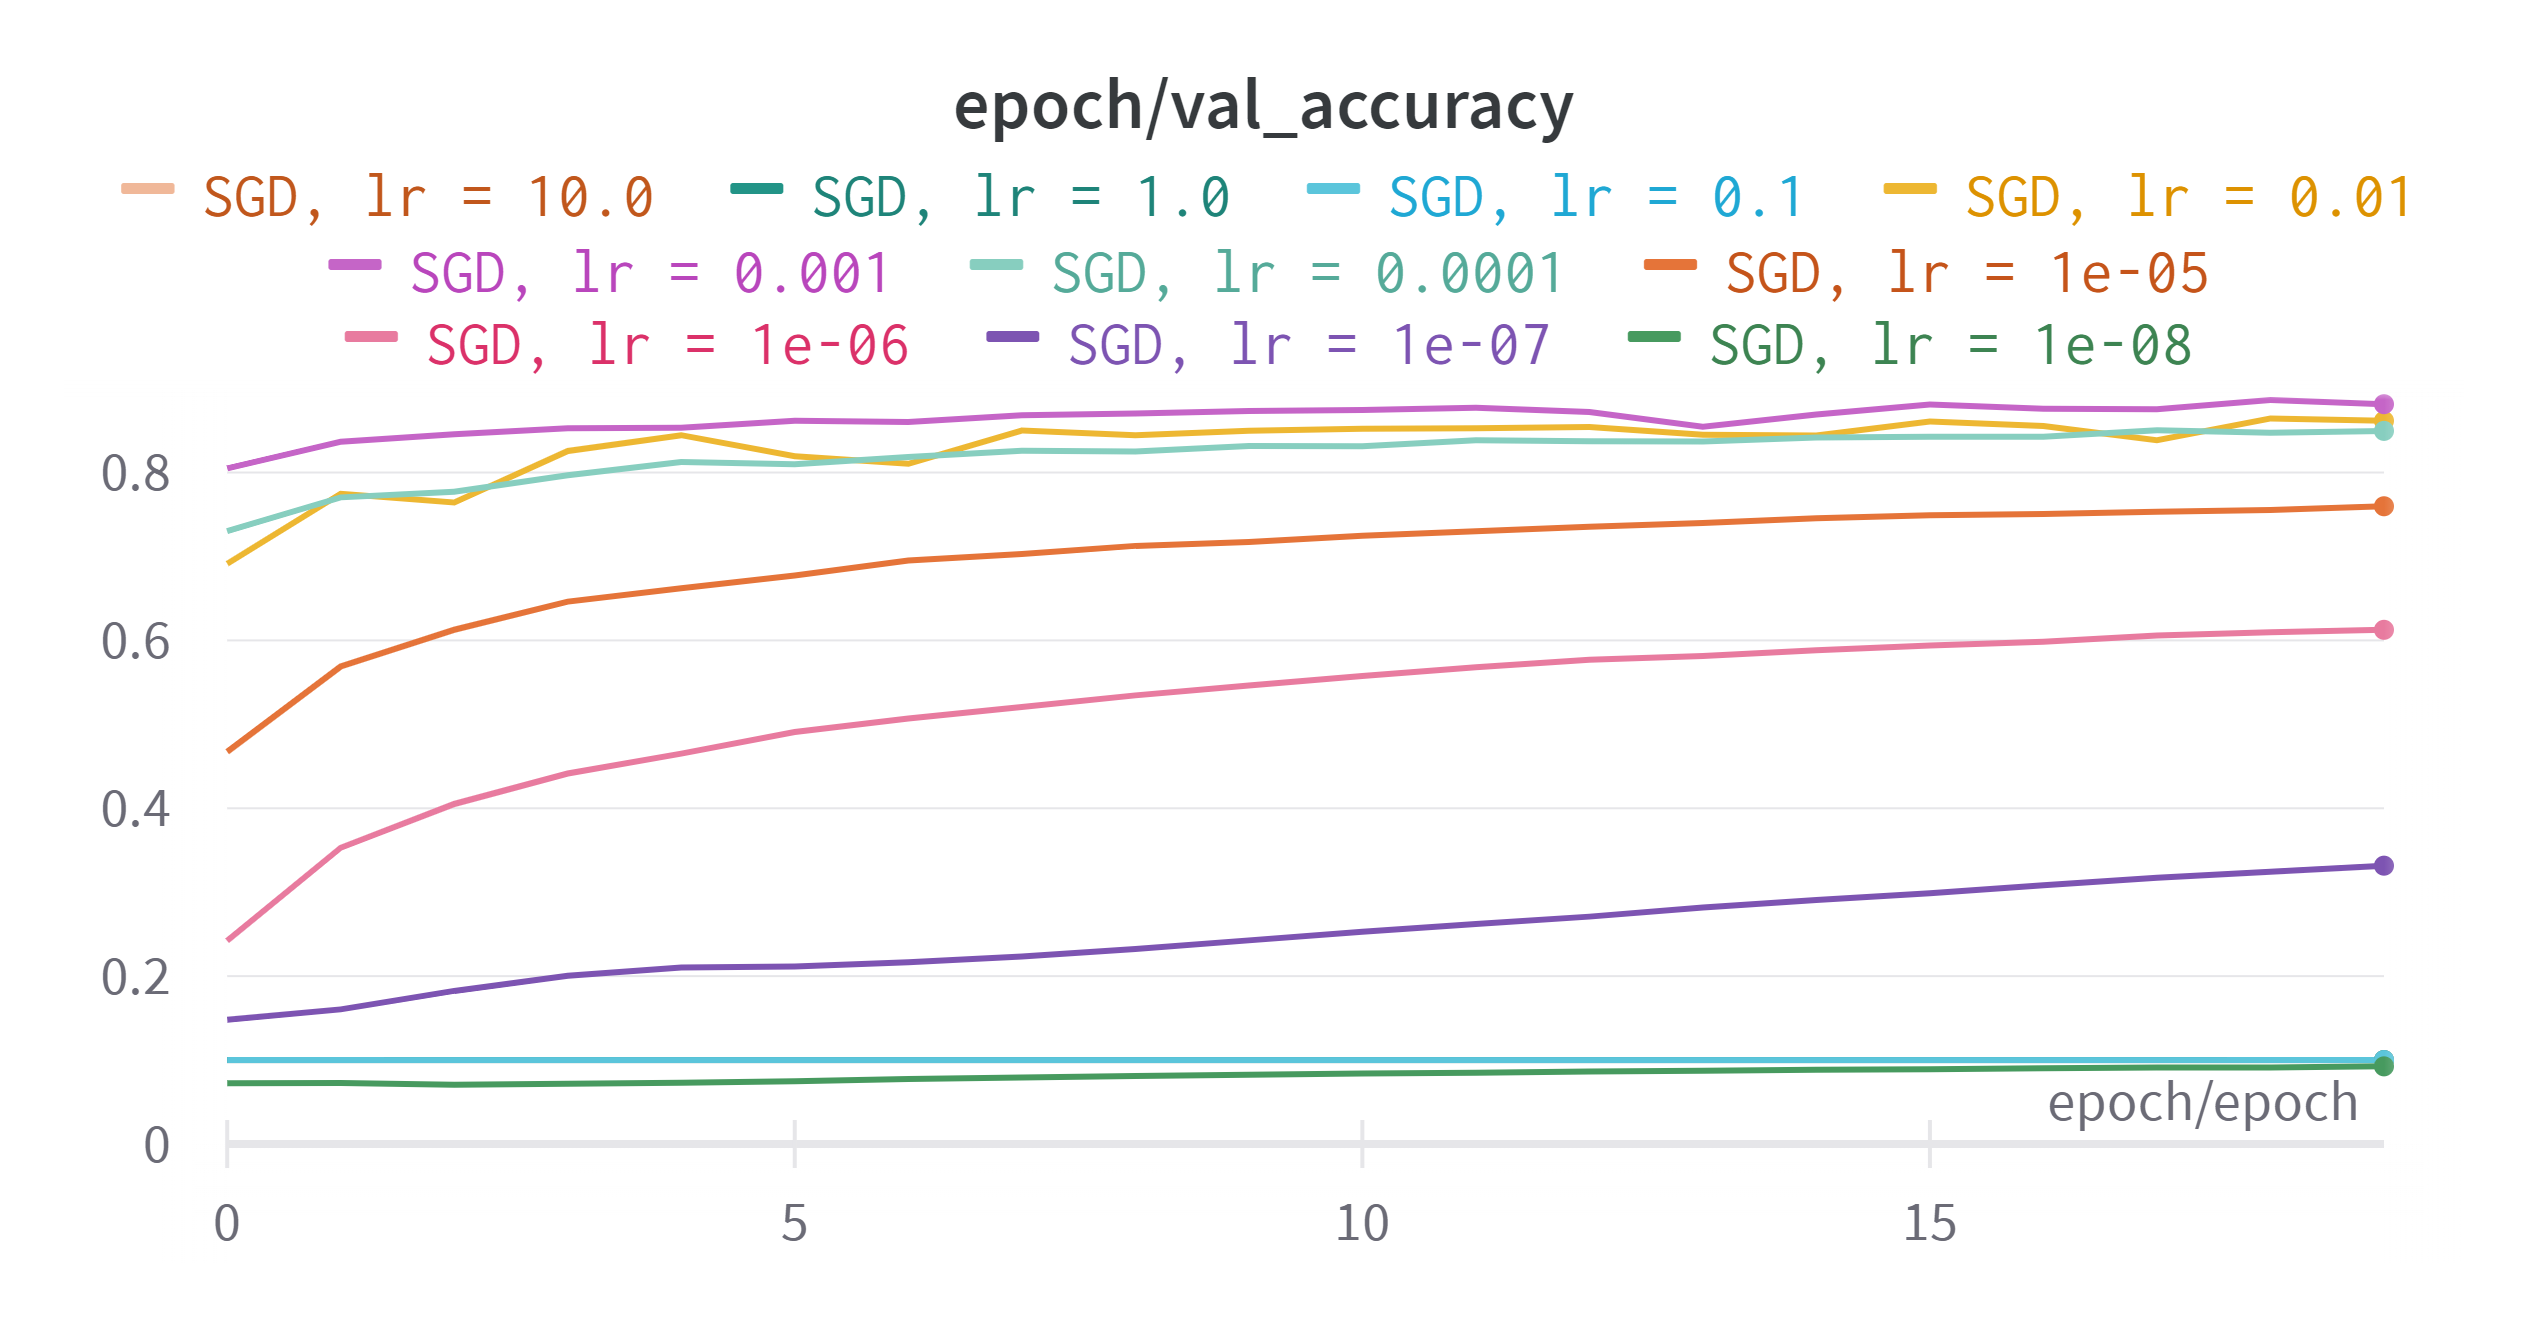

### Cross-Validation

Use 5-fold cross validation to estimate the accuracy and an error bar of the accuracy estimate.


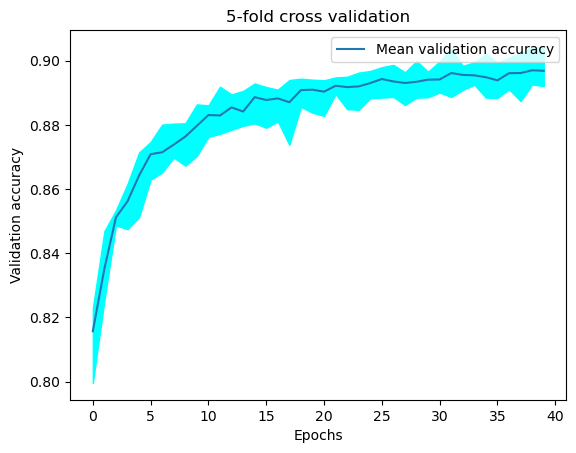

In [62]:
#!! THIS TAKE A WHILE TO EXECUTE!!
### YOUR CODE HERE ###
from sklearn.model_selection import KFold

# Learning rate from best model
nepochs = 40
lr = 0.001

kf = KFold(n_splits=5, shuffle=True)
val_acc_hist = []

for train_idx, test_idx in kf.split(X_train):
    model = cnn_model(n_classes=n_classes)
    model.compile(
        loss=keras.losses.categorical_crossentropy,
        optimizer=keras.optimizers.SGD(learning_rate=lr),
        metrics=["accuracy"]
    )
    log = model.fit(
        x=X_train[train_idx],
        y=y_train[train_idx],
        batch_size=batch_size,
        epochs=nepochs,
        validation_data=(X_train[test_idx], y_train[test_idx]),
        verbose=0
    )
    val_acc_hist.append(log.history['val_accuracy'])

plt.plot(np.mean(val_acc_hist, axis=0), label="Mean validation accuracy")
plt.fill_between(x=range(nepochs), y1=np.min(val_acc_hist, axis=0), y2=np.max(val_acc_hist, axis=0), color="cyan")
plt.title("5-fold cross validation")
plt.xlabel("Epochs")
plt.ylabel("Validation accuracy")
plt.legend()
plt.show()

### Analyse Different Optimisers with different Settings 

Use the code above to explore different settings for the different optimizers. Use batchsize 64.

1. *SGD*: Refer to the results from above - for later comparison.
<br>

2. *Momentum*: Play with at least three different settings when using momentum: learning rate, momentum parameter, Nesterov flag. Start with momentum=0.9 without Nesterov and suitable learning rate, then vary the momentum parameter and independently the learning rate. Can you see an impact of using Nesterov? What is your recommended best choice (lr, momentum, nesterov, nepochs) for the given problem?
<br>

3. *RMSProp*: Same thing now for RMSprop (without momentum). Play with at least three different settings when using RMSprop: lr, alpha. Start with the default settings of pytorch with (lr=0.01, alpha=0.99,centered=False). Then vary alpha and independently the learning rate. Can you see an impact when using centered=True? What is your recommended best choice (learning rate, alpha, centered, nepochs) for the given problem?<br>
<br>

4. *Adam*: Same thing now for Adam. Play with at least three different settings. Start with the default settings of pytorch. What is your recommended best choice for the given problem?<br>
<br>


In [8]:
batch_size = 64
nepochs = 25

""" 1. SGD"""
lr = 0.001
model = cnn_model(n_classes=n_classes)
model.compile(
    loss=keras.losses.categorical_crossentropy,
    optimizer=keras.optimizers.SGD(learning_rate=lr),
    metrics=["accuracy"]
)
wandb.init(config={"bs": 12}, name="SGD (no momentum, no nesterov)")
log = model.fit(
    x=X_train,
    y=y_train,
    batch_size=batch_size,
    epochs=nepochs,
    validation_data=(X_test, y_test),
    callbacks=[WandbMetricsLogger()],
    verbose=0
)
wandb.finish()

epoch/accuracy,▁▅▅▆▆▆▇▇▇▇▇▇▇▇███████████
epoch/epoch,▁▁▂▂▂▂▃▃▃▄▄▄▅▅▅▅▆▆▆▇▇▇▇██
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/val_accuracy,▁▃▄▅▅▅▆▇▇▆▆▇▇▇█▇▇█▇▇██▇██
epoch/val_loss,█▆▅▄▄▄▃▂▃▃▂▂▃▂▂▁▁▁▁▂▁▁▂▁▁
epoch/accuracy,0.91236
epoch/epoch,24
epoch/learning_rate,0.001
epoch/loss,0.24633
epoch/val_accuracy,0.8914


In [64]:
""" 2. SGD with Momentum / no Nesterov"""
lr = 0.001
momentum = 0.9
model = cnn_model(n_classes=n_classes)
model.compile(
    loss=keras.losses.categorical_crossentropy,
    optimizer=keras.optimizers.SGD(learning_rate=lr, momentum=momentum, nesterov=False),
    metrics=["accuracy"]
)
wandb.init(config={"bs": 12}, name="SGD (no nesterov), momentum = " + str(momentum))
log = model.fit(
    x=X_train,
    y=y_train,
    batch_size=batch_size,
    epochs=nepochs,
    validation_data=(X_test, y_test),
    callbacks=[WandbMetricsLogger()],
    verbose=0
)
wandb.finish(quiet=True)

epoch/accuracy,▁▅▆▆▆▇▇▇▇▇▇▇█████████████
epoch/epoch,▁▁▂▂▂▂▃▃▃▄▄▄▅▅▅▅▆▆▆▇▇▇▇██
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/val_accuracy,▁▄▄▆▅▆▇▇▇▇▇▇▇▇▇██▇▇▇▇█▇▇█
epoch/val_loss,█▅▅▄▄▃▂▂▂▂▂▃▁▂▂▁▁▂▂▁▁▁▁▂▂
epoch/accuracy,0.9023
epoch/epoch,24
epoch/learning_rate,0.001
epoch/loss,0.26689
epoch/val_accuracy,0.8805


In [9]:
""" 2. SGD with Momentum / Nesterov"""
lr = 0.001
momentum = 0.9
model = cnn_model(n_classes=n_classes)
model.compile(
    loss=keras.losses.categorical_crossentropy,
    optimizer=keras.optimizers.SGD(learning_rate=lr, momentum=momentum, nesterov=True),
    metrics=["accuracy"]
)
wandb.init(config={"bs": 12}, name="SGD (incl. nesterov), momentum = " + str(momentum))
log = model.fit(
    x=X_train,
    y=y_train,
    batch_size=batch_size,
    epochs=nepochs,
    validation_data=(X_test, y_test),
    callbacks=[WandbMetricsLogger()],
    verbose=0
)
wandb.finish(quiet=True)

In [10]:
""" 2. SGD with Momentum / Nesterov --> Find best parameters"""
import itertools

nepochs = 10
nesterov_list = [False, True]
lr_list = np.logspace(-5, -3, 3)
momentum_list = np.logspace(-2, 0, 3)*0.9

a = [nesterov_list, lr_list, momentum_list]
for nesterov, lr, momentum in list(itertools.product(*a)):
    model.compile(
        loss=keras.losses.categorical_crossentropy,
        optimizer=keras.optimizers.SGD(learning_rate=lr, momentum=momentum, nesterov=nesterov),
        metrics=["accuracy"]
    )
    wandb.init(config={"bs": 12}, name=f"SGD lr={lr}, momentum = {momentum}, nesterov={nesterov}", group="SGD hyperparameter tuning")
    log = model.fit(
        x=X_train,
        y=y_train,
        batch_size=batch_size,
        epochs=nepochs,
        validation_data=(X_test, y_test),
        callbacks=[WandbMetricsLogger()],
        verbose=0
    )
    wandb.finish()

epoch/accuracy,▁▄▅▆▆▇████
epoch/epoch,▁▂▃▃▄▅▆▆▇█
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▅▄▃▂▂▂▁▁▁
epoch/val_accuracy,▁▃▄▆▆▇▇▇▇█
epoch/val_loss,█▅▄▃▃▂▂▂▁▁
epoch/accuracy,0.92448
epoch/epoch,9
epoch/learning_rate,1e-05
epoch/loss,0.20819
epoch/val_accuracy,0.8944


epoch/accuracy,▁▃▃▄▄▅▆▇▇█
epoch/epoch,▁▂▃▃▄▅▆▆▇█
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▇▆▅▄▄▃▂▂▁
epoch/val_accuracy,▁▄▄▃▄▆▆▆██
epoch/val_loss,█▇▆▅▄▃▃▂▂▁
epoch/accuracy,0.92674
epoch/epoch,9
epoch/learning_rate,1e-05
epoch/loss,0.20454
epoch/val_accuracy,0.896


epoch/accuracy,▁▃▃▄▆▆▆█▇█
epoch/epoch,▁▂▃▃▄▅▆▆▇█
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▆▅▄▄▃▂▂▁▁
epoch/val_accuracy,█▇▁▃▄▇▇▄▇▇
epoch/val_loss,█▇▆▅▃▂▃▂▁▁
epoch/accuracy,0.9298
epoch/epoch,9
epoch/learning_rate,1e-05
epoch/loss,0.1973
epoch/val_accuracy,0.8956


epoch/accuracy,▁▃▃▃▄▅▅█▆▆
epoch/epoch,▁▂▃▃▄▅▆▆▇█
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▇▆▅▄▃▃▂▁▁
epoch/val_accuracy,▄▂▂█▆▁▄▇▄▃
epoch/val_loss,▆█▄▂▄▆▁▅▃▁
epoch/accuracy,0.93032
epoch/epoch,9
epoch/learning_rate,0.0001
epoch/loss,0.19502
epoch/val_accuracy,0.8951


epoch/accuracy,▄▂▁█▃▁▃▇▆▆
epoch/epoch,▁▂▃▃▄▅▆▆▇█
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▇▇▆▅▄▄▂▂▁
epoch/val_accuracy,▁▃▂▂▅▇▆█▅▅
epoch/val_loss,▅▃▄▂▃▂▂▁▅█
epoch/accuracy,0.93074
epoch/epoch,9
epoch/learning_rate,0.0001
epoch/loss,0.19336
epoch/val_accuracy,0.8956


epoch/accuracy,▁▁▁▂▅▅▄█▇▆
epoch/epoch,▁▂▃▃▄▅▆▆▇█
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▇▆▅▄▄▃▂▁▁
epoch/val_accuracy,▅█▃▆▂▁▆▂▁█
epoch/val_loss,▁▃▂▃▅█▄▃▆▄
epoch/accuracy,0.9303
epoch/epoch,9
epoch/learning_rate,0.0001
epoch/loss,0.19314
epoch/val_accuracy,0.8964


epoch/accuracy,▂▁▃▆▆█▆▃▄▆
epoch/epoch,▁▂▃▃▄▅▆▆▇█
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▆▅▅▄▃▃▃▃▁
epoch/val_accuracy,▇█▂▆▁▆█▇▅▆
epoch/val_loss,▁▁█▁▆▅▂▃█▃
epoch/accuracy,0.93108
epoch/epoch,9
epoch/learning_rate,0.001
epoch/loss,0.18947
epoch/val_accuracy,0.8931


epoch/accuracy,▄▄▅█▂▁▅▄▇█
epoch/epoch,▁▂▃▃▄▅▆▆▇█
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▇▆▅▅▃▃▂▂▁
epoch/val_accuracy,▄▆▂▅▇▂▁▅▁█
epoch/val_loss,▁▃▄▂▄▄▄▆█▂
epoch/accuracy,0.93316
epoch/epoch,9
epoch/learning_rate,0.001
epoch/loss,0.18632
epoch/val_accuracy,0.895


epoch/accuracy,▁▃▄▅▄▅▇▇▅█
epoch/epoch,▁▂▃▃▄▅▆▆▇█
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▇▆▅▆▃▃▃▄▁
epoch/val_accuracy,▅▇▂█▁▆▆▃█▄
epoch/val_loss,▆▁▆▁█▃▄▄▂▅
epoch/accuracy,0.91494
epoch/epoch,9
epoch/learning_rate,0.001
epoch/loss,0.23124
epoch/val_accuracy,0.8806


epoch/accuracy,▁▄▆▆▇▇████
epoch/epoch,▁▂▃▃▄▅▆▆▇█
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▅▄▃▃▂▂▂▁▁
epoch/val_accuracy,▁▃▄▆▆▆▇▇██
epoch/val_loss,█▆▅▄▃▃▂▂▁▁
epoch/accuracy,0.9292
epoch/epoch,9
epoch/learning_rate,1e-05
epoch/loss,0.19335
epoch/val_accuracy,0.8913


epoch/accuracy,▁▁▃▄▅▆▆▆▇█
epoch/epoch,▁▂▃▃▄▅▆▆▇█
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▇▆▅▄▄▃▂▂▁
epoch/val_accuracy,▁▄▄▅▄▆▆▇█▇
epoch/val_loss,█▇▆▅▄▄▃▂▂▁
epoch/accuracy,0.93194
epoch/epoch,9
epoch/learning_rate,1e-05
epoch/loss,0.1875
epoch/val_accuracy,0.8928


epoch/accuracy,▁▃▄▆▆▇▆▇██
epoch/epoch,▁▂▃▃▄▅▆▆▇█
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▆▅▄▃▃▂▂▁▁
epoch/val_accuracy,▃▁▃▄▆▅▅█▇▇
epoch/val_loss,█▅▄▂▁▃▁▁▁▁
epoch/accuracy,0.93624
epoch/epoch,9
epoch/learning_rate,1e-05
epoch/loss,0.17666
epoch/val_accuracy,0.8962


epoch/accuracy,▂▁▄▄▅▅▇▆██
epoch/epoch,▁▂▃▃▄▅▆▆▇█
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▇▆▅▅▄▃▂▂▁
epoch/val_accuracy,▇▃█▄▆▁▆▂▃▄
epoch/val_loss,▅▄▄▂▅▄▃▁█▁
epoch/accuracy,0.93744
epoch/epoch,9
epoch/learning_rate,0.0001
epoch/loss,0.17383
epoch/val_accuracy,0.8965


epoch/accuracy,▁▃▄▃▅▅▅█▅▅
epoch/epoch,▁▂▃▃▄▅▆▆▇█
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▇▆▅▅▃▃▂▂▁
epoch/val_accuracy,▇█▁▇█▆▇▆▇▆
epoch/val_loss,█▅▇▅▅▃▁▃▄▁
epoch/accuracy,0.93806
epoch/epoch,9
epoch/learning_rate,0.0001
epoch/loss,0.17208
epoch/val_accuracy,0.8965


epoch/accuracy,▁▂▁▄▅▅▆▆█▇
epoch/epoch,▁▂▃▃▄▅▆▆▇█
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁
epoch/loss,██▆▅▅▄▃▃▁▁
epoch/val_accuracy,▆█▄▃▄▅▁▅▄▆
epoch/val_loss,█▂▁▆▄█▄▃▅█
epoch/accuracy,0.93818
epoch/epoch,9
epoch/learning_rate,0.0001
epoch/loss,0.17086
epoch/val_accuracy,0.8958


epoch/accuracy,▁▄▁▅▄▇██▅▅
epoch/epoch,▁▂▃▃▄▅▆▆▇█
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▇▇▅▄▄▂▂▁▁
epoch/val_accuracy,▆▆▃█▇█▅▁▄▂
epoch/val_loss,▄▂▅▁▃▃▄█▅▇
epoch/accuracy,0.93876
epoch/epoch,9
epoch/learning_rate,0.001
epoch/loss,0.16819
epoch/val_accuracy,0.8904


epoch/accuracy,▁▄▁▆▃▄▃▄▅█
epoch/epoch,▁▂▃▃▄▅▆▆▇█
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▇▆▆▆▅▄▃▃▁
epoch/val_accuracy,█▄▆▁▄▆▂██▅
epoch/val_loss,▁▁▃▇▇▂█▅▂█
epoch/accuracy,0.94074
epoch/epoch,9
epoch/learning_rate,0.001
epoch/loss,0.16501
epoch/val_accuracy,0.8931


epoch/accuracy,▁▂▁▆▆▄█▅█▇
epoch/epoch,▁▂▃▃▄▅▆▆▇█
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▇▆▄▃▄▂▂▁▁
epoch/val_accuracy,█▇▃▆▁▇█▅▇█
epoch/val_loss,▁▁█▂█▂▄▃▃▃
epoch/accuracy,0.9225
epoch/epoch,9
epoch/learning_rate,0.001
epoch/loss,0.20993
epoch/val_accuracy,0.8871


In [14]:
""" 3. RMSProp --> Find best parameters"""
nepochs = 15
centered_list = [False, True]
lr_list = np.logspace(-5, -3, 3)
alpha_list = np.logspace(-2, 0, 3)*0.99


a = [centered_list, lr_list, alpha_list]
for centered, lr, alpha in list(itertools.product(*a)):
    model.compile(
        loss=keras.losses.categorical_crossentropy,
        optimizer=keras.optimizers.RMSprop(learning_rate=lr, centered=centered, rho=alpha),
        metrics=["accuracy"]
    )
    wandb.init(config={"bs": 12}, name=f"RMSProp lr={lr}, alpha = {alpha}, centered={centered}", group="RMSProp hyperparameter tuning")
    log = model.fit(
        x=X_train,
        y=y_train,
        batch_size=batch_size,
        epochs=nepochs,
        validation_data=(X_test, y_test),
        callbacks=[WandbMetricsLogger()],
        verbose=0
    )
    wandb.finish(quiet=True)

In [35]:
""" 4. Adam --> Find best parameters"""
nepochs = 10
lr_list = np.logspace(-5, -3, 3)
beta_1_list = np.logspace(-2, 0, 3)*0.9    # Momentum
beta_2_list = np.logspace(-2, 0, 3)*0.999  # RMS Decay

a = [lr_list, beta_1_list, beta_2_list]
for lr, beta_1, beta_2 in list(itertools.product(*a)):
    model = cnn_model(n_classes=n_classes)
    model.compile(
        loss=keras.losses.categorical_crossentropy,
        optimizer=keras.optimizers.Adam(learning_rate=lr, beta_1=beta_1, beta_2=beta_2),
        metrics=["accuracy"]
    )
    wandb.init(config={"bs": 12}, name=f"Adam lr={lr}, beta_1 = {beta_1}, beta_2={beta_2}", group="Adam hyperparameter tuning 3")
    log = model.fit(
        x=X_train,
        y=y_train,
        batch_size=batch_size,
        epochs=nepochs,
        validation_data=(X_test, y_test),
        callbacks=[WandbMetricsLogger()],
        verbose=0
    )
    wandb.finish(quiet=True)

### Plots and Comments (for the different steps described above) 

SGD tuning (part 2): There is no clear winner. There are multiple settings which seem to work equally well e.g. (lr=0.001, momentum=0.09, nesterov=True) and (lr=0.001, momentum=0.009, nesterov=True) and (lr=1e-5, momentum=0.9, nesterov=True). In any case Nesterov seems to be a good choice.
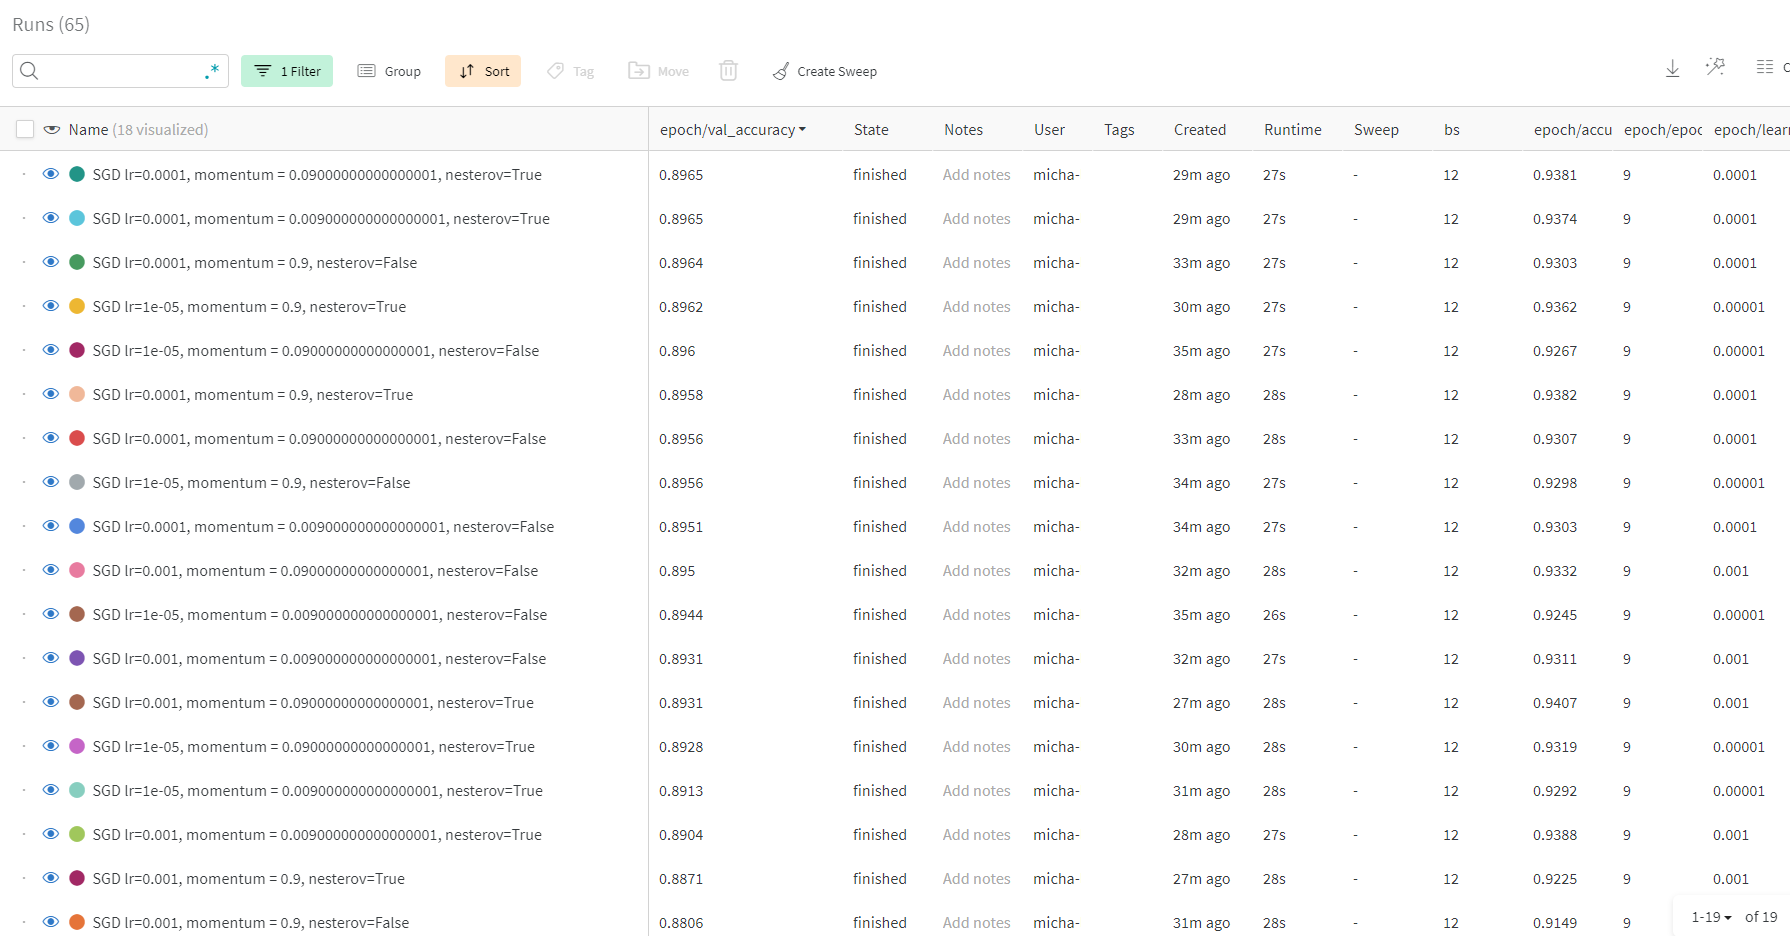
    

RMSProp tuning (part 3): there is no clear winner here either. But some settings don't work at all! The best 3 models all share the same learning rate (1e-05) so this seems to be a good setting. Also all models with centered = True fail to learn.
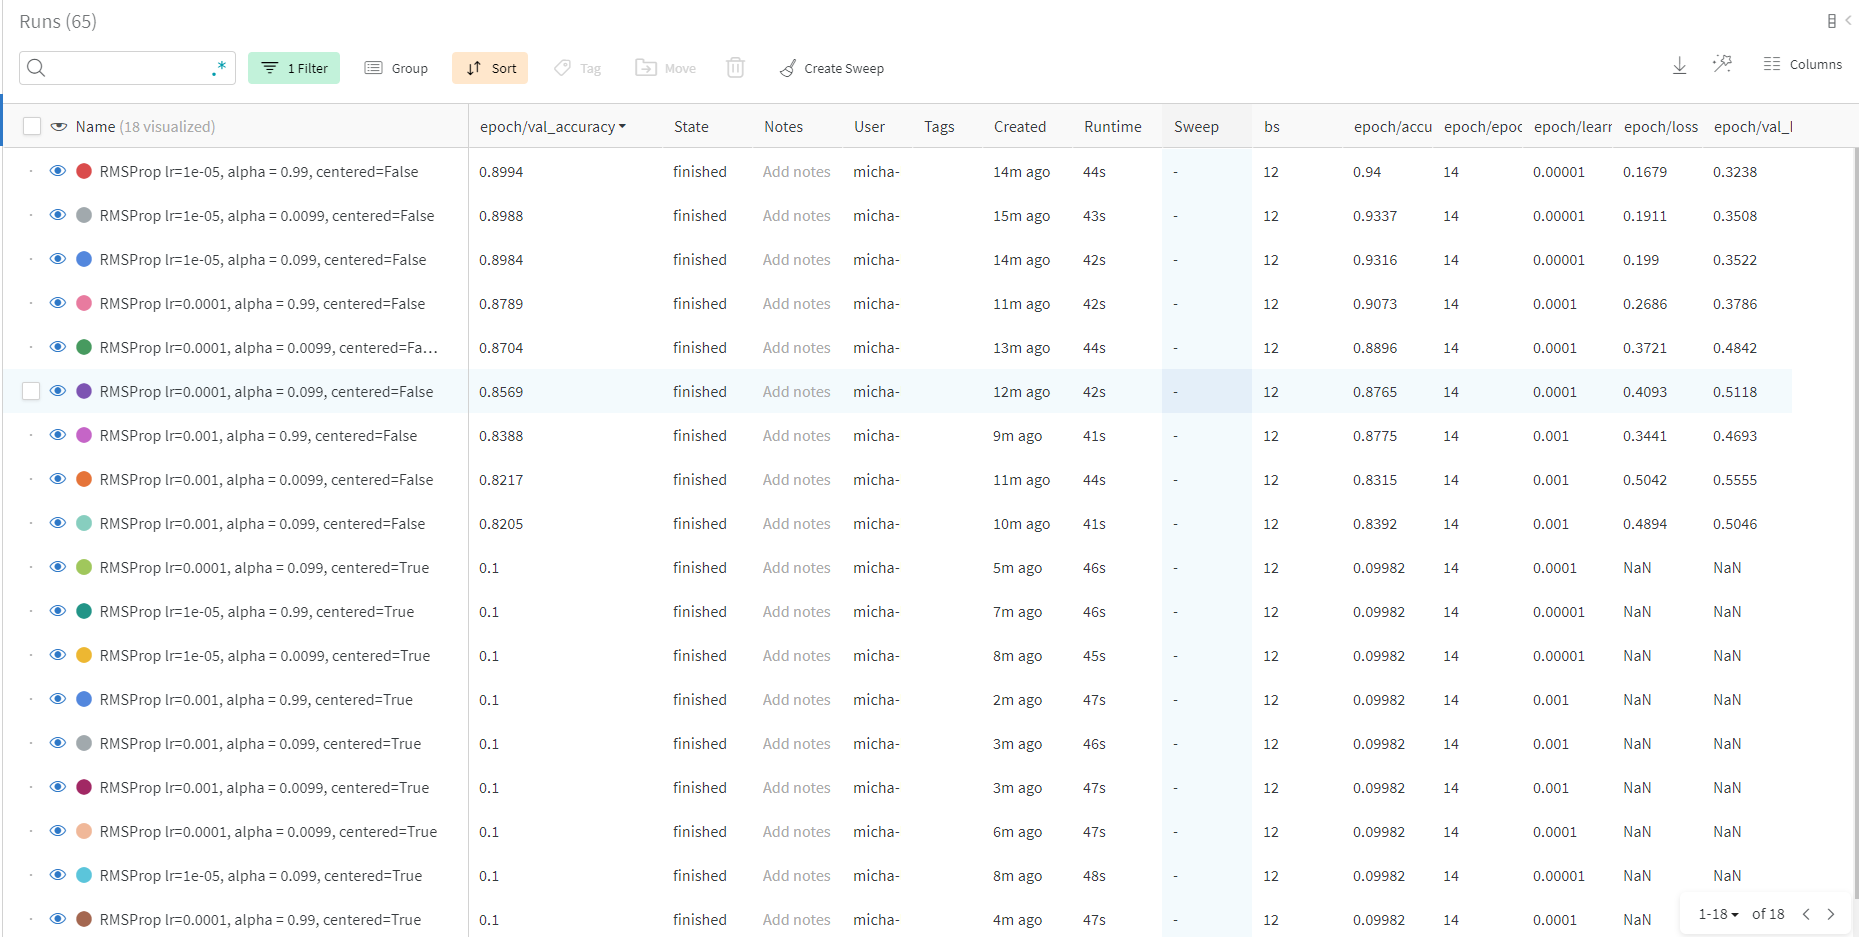

Adam tuning (part 4): The most important setting seems to be the learning rate. All the best models share the same learning rate and also the same beta_2. The best result was achieved with (lr=0.001, beta_1=0.9 and beta_2=0.999).
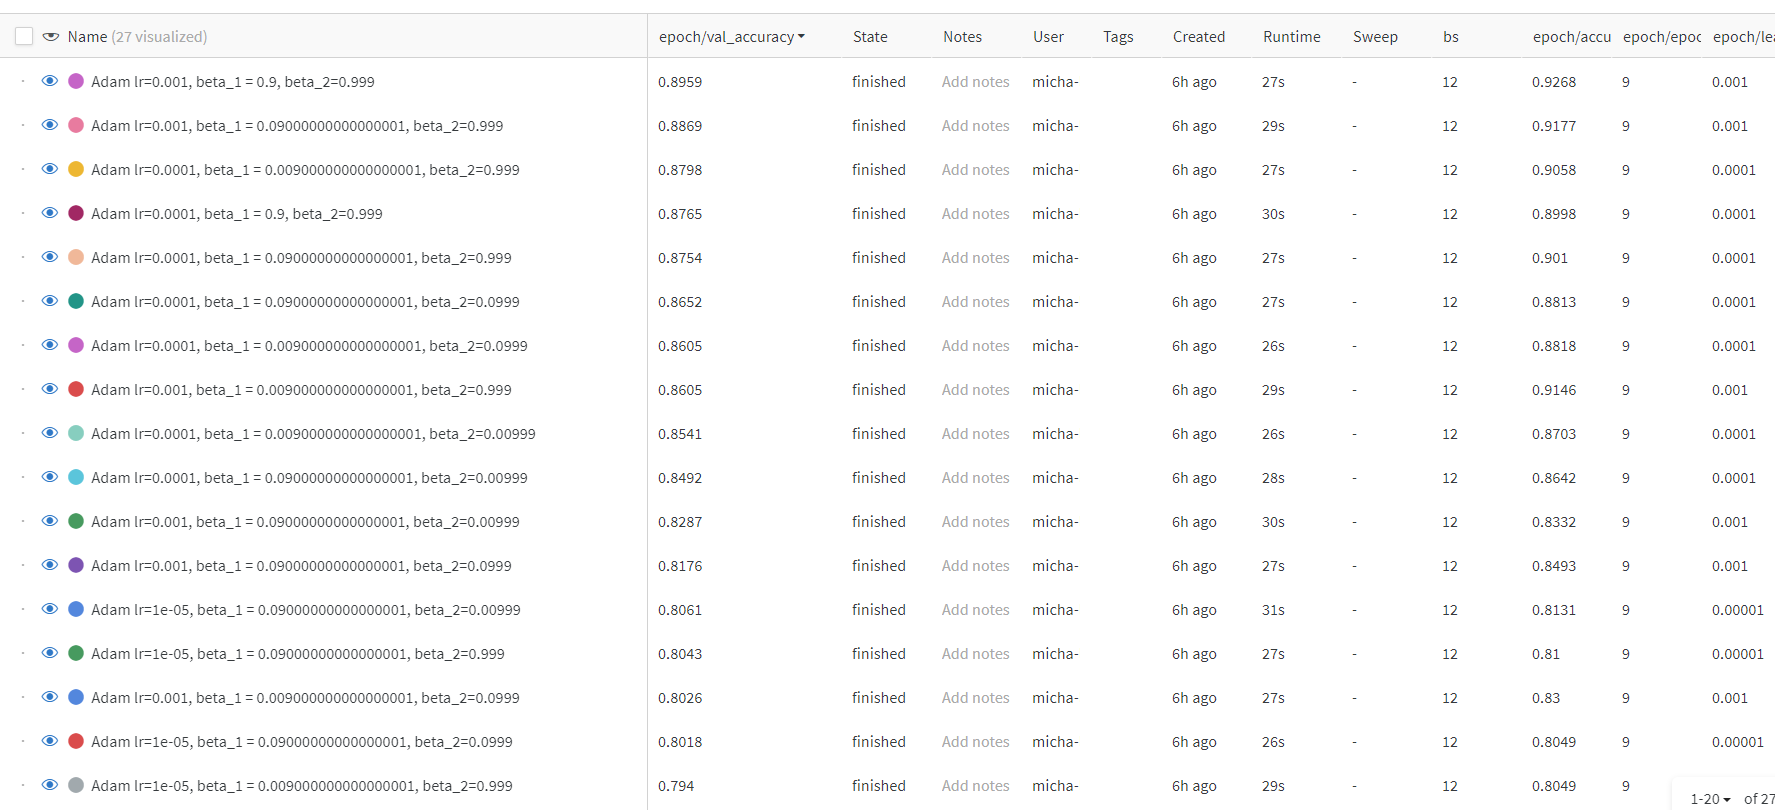

### Learning Rate Schedule

Modify your `train_eval` method implemented above to support using a learning rate schedule for SGD (without momentum) - by using e.g. StepLR. What are your preferred settings for the given task?

Compare and evaluate the training performance with the results obtained for the different optimizers above and provide a judgement.

Epoch 1/30
782/782 [==============================] - 2s 3ms/step - loss: 0.7888 - accuracy: 0.7685 - val_loss: 0.5809 - val_accuracy: 0.7986 - lr: 0.0010
Epoch 2/30
782/782 [==============================] - 2s 2ms/step - loss: 0.4474 - accuracy: 0.8441 - val_loss: 0.4756 - val_accuracy: 0.8344 - lr: 0.0010
Epoch 3/30
782/782 [==============================] - 2s 2ms/step - loss: 0.3962 - accuracy: 0.8599 - val_loss: 0.4884 - val_accuracy: 0.8359 - lr: 0.0010
Epoch 4/30
782/782 [==============================] - 2s 2ms/step - loss: 0.3682 - accuracy: 0.8715 - val_loss: 0.4598 - val_accuracy: 0.8450 - lr: 0.0010
Epoch 5/30
782/782 [==============================] - 2s 2ms/step - loss: 0.3491 - accuracy: 0.8775 - val_loss: 0.4121 - val_accuracy: 0.8536 - lr: 0.0010
Epoch 6/30
782/782 [==============================] - 2s 2ms/step - loss: 0.3340 - accuracy: 0.8822 - val_loss: 0.4044 - val_accuracy: 0.8566 - lr: 0.0010
Epoch 7/30
782/782 [==============================] - 2s 2ms/step - lo

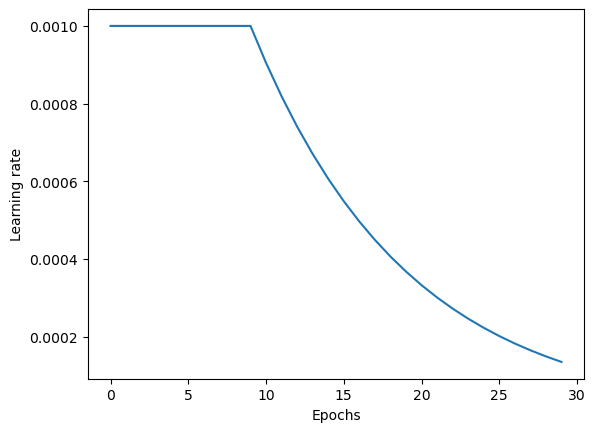

In [22]:
# This function keeps the initial learning rate for the first ten epochs
# and decreases it exponentially after that.
def scheduler(epoch, lr):
    if epoch < 10:
        return lr
    else:
        return lr * tf.math.exp(-0.1)

nepochs = 30    
lr = 0.001
batch_size = 64
model = cnn_model(n_classes=n_classes)
model.compile(
        loss=keras.losses.categorical_crossentropy,
        optimizer=keras.optimizers.SGD(learning_rate=lr),
        metrics=["accuracy"]
)
callback = tf.keras.callbacks.LearningRateScheduler(scheduler)   
log = model.fit(
        x=X_train,
        y=y_train,
        batch_size=batch_size,
        epochs=nepochs,
        validation_data=(X_test, y_test),
        callbacks=[callback],
)
plt.plot(range(nepochs), log.history["lr"])
plt.xlabel("Epochs")
plt.ylabel("Learning rate")
plt.show()

This lab has shown that tuning the optimizer correctly is important and can really influence the performance of the model because with poor settings the model fails to learn the patterns and might get stuck in a poor local minima. While it seems to be possible to achieve good results with all optimizers that we used, it definitely makes sense to use a more sophisticated optimizer such as Adam. In our lab RMSProp has been the most sensible to bad hyperparameters.